In [38]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


pd.set_option('display.max_columns', None)

In [39]:
from sklearn.model_selection import train_test_split


df = pd.read_csv("../data/train.csv")


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

# Data Cleansing

#### 🧹 Handling Missing Values (Feature Absence)


In [41]:
null_cols = df.columns[df.isnull().any()]
null_df = df[null_cols].copy()


In [5]:
# for col in null_df.select_dtypes(include='object').columns:
# 	print(null_df[col].value_counts(dropna=False))
# 	print()

In [42]:
null_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LotFrontage   1201 non-null   float64
 1   Alley         91 non-null     object 
 2   MasVnrType    588 non-null    object 
 3   MasVnrArea    1452 non-null   float64
 4   BsmtQual      1423 non-null   object 
 5   BsmtCond      1423 non-null   object 
 6   BsmtExposure  1422 non-null   object 
 7   BsmtFinType1  1423 non-null   object 
 8   BsmtFinType2  1422 non-null   object 
 9   Electrical    1459 non-null   object 
 10  FireplaceQu   770 non-null    object 
 11  GarageType    1379 non-null   object 
 12  GarageYrBlt   1379 non-null   float64
 13  GarageFinish  1379 non-null   object 
 14  GarageQual    1379 non-null   object 
 15  GarageCond    1379 non-null   object 
 16  PoolQC        7 non-null      object 
 17  Fence         281 non-null    object 
 18  MiscFeature   54 non-null   

In [43]:
cat_null_cols = null_df.select_dtypes(include='object').columns
num_null_cols = null_df.select_dtypes(include='number').columns


bsmt_null_cols = cat_null_cols[cat_null_cols.str.contains('Bsmt')]
garage_null_cols = cat_null_cols[cat_null_cols.str.contains('Garage')]


dict = {
    'Alley': 'NoAlley',
    'Electrical': df.Electrical.mode()[0],
    'FireplaceQu': df.FireplaceQu.mode()[0],
    'Fence': 'NoFence',
    'MiscFeature': 'None',
    'PoolQC': 'NoPool',
    'MasVnrType': 'None',
    **{bsmt_col: 'NoBsmtAvl' for bsmt_col in bsmt_null_cols},
    **{garage_col: 'NoGarageAvl' for garage_col in garage_null_cols},
    **{num_col: int(null_df[num_col].mean()) for num_col in num_null_cols}
}


null_df.fillna(dict, inplace=True)
df.update(null_df) # No Missing Value left data is fully cleansed

In [ ]:
null_df.mean(numeric_only=True)

In [44]:
df.drop(columns='Id', inplace=True)

#### EDA

In [45]:
# df.select_dtypes(include='number')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1460 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          1460 non-null   object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [46]:
df[['MSSubClass', 'OverallQual', 'OverallCond', 'MoSold']] = df[['MSSubClass', 'OverallQual', 'OverallCond', 'MoSold']].astype('object')

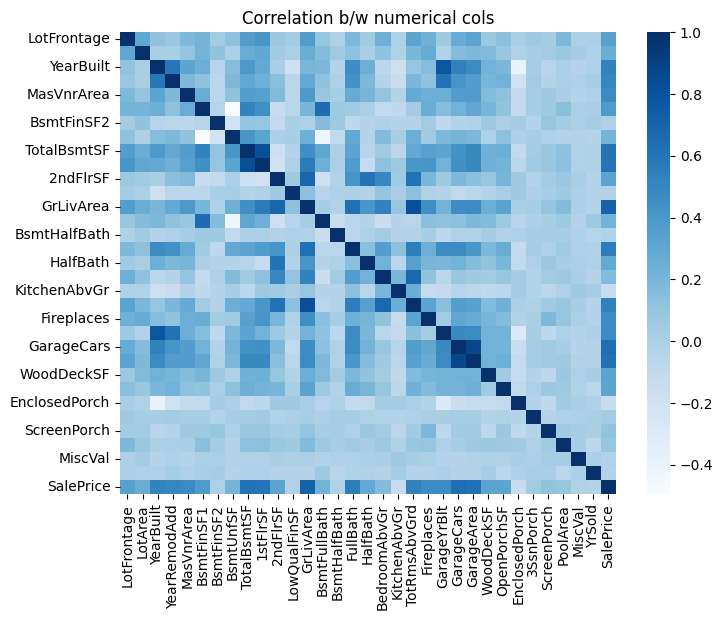

In [47]:

hn =  df.select_dtypes(include='number').corr()
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(hn, cmap='Blues', ax=ax)
plt.title('Correlation b/w numerical cols')
plt.show()

Interpretation:

    X-axis: Correlation values (from -1 to 1).

    Y-axis: Number of features that have that correlation with the current feature.

So, for each feature:

    A peak near 1 → Strong positive correlation with many features.

    A peak near 0 → Mostly uncorrelated.

    A peak near -1 → Strong negative correlation.

It helps you see how strongly each feature is generally related to others.

In [ ]:
# hn.hist(figsize=(16, 14), bins=50, xlabelsize=8, ylabelsize=8)

In [48]:
cors = df.corr(numeric_only=True)['SalePrice'].sort_values(ascending=False).to_frame()

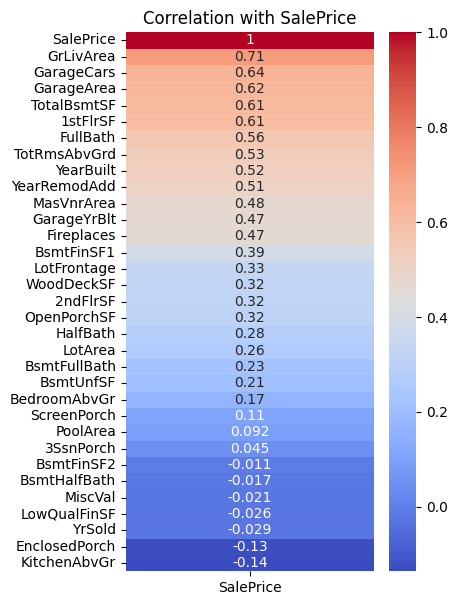

In [13]:
# Plot heatmap
fig, ax = plt.subplots(figsize=(4,7))
sns.heatmap(cors, annot=True, cmap='coolwarm', ax=ax)
plt.title('Correlation with SalePrice')
plt.show()

**feature selection numerical**

In [49]:
high_corr_features = cors.query("SalePrice > 0.45") #columns(features) highly correlated to SalePrice
high_corr_features.iloc[1:]


,SalePrice
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
FullBath,0.560664
TotRmsAbvGrd,0.533723
YearBuilt,0.522897
YearRemodAdd,0.507101
MasVnrArea,0.475227


In [ ]:
# fig, ax = plt.subplots(figsize=(18,10))
g = sns.pairplot(df, y_vars='SalePrice', x_vars=high_corr_features.index, kind='scatter')
g.figure.set_size_inches(20,6)

In [ ]:
sns.boxplot(x=df['SalePrice'])

In [ ]:
from sklearn.feature_selection import f_regression

y = df['SalePrice']
categorical_df = df.select_dtypes(include='object')
X_encoded = pd.get_dummies(categorical_df, drop_first=True)
f_scores, _ = f_regression(X_encoded, y)
pd.Series(f_scores, index=X_encoded.columns).sort_values(ascending=False)

In [50]:
Q3 = df['SalePrice'].quantile(0.75)
Q1 = df['SalePrice'].quantile(0.25)
IQR = Q3 - Q1

iqr_df = df[(df['SalePrice'] > Q1 - 1.5*IQR) & (df['SalePrice'] < Q3 + 1.5*IQR)]
final_df = iqr_df[high_corr_features.index]
final_df

,SalePrice,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd,MasVnrArea,GarageYrBlt,Fireplaces
0,208500,1710,2,548,856,856,2,8,2003,2003,196.0,2003.0,0
1,181500,1262,2,460,1262,1262,2,6,1976,1976,0.0,1976.0,1
2,223500,1786,2,608,920,920,2,6,2001,2002,162.0,2001.0,1
3,140000,1717,3,642,756,961,1,7,1915,1970,0.0,1998.0,1
4,250000,2198,3,836,1145,1145,2,9,2000,2000,350.0,2000.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,175000,1647,2,460,953,953,2,7,1999,2000,0.0,1999.0,1
1456,210000,2073,2,500,1542,2073,2,7,1978,1988,119.0,1978.0,2
1457,266500,2340,1,252,1152,1188,2,9,1941,2006,0.0,1941.0,2
1458,142125,1078,1,240,1078,1078,1,5,1950,1996,0.0,1950.0,0


In [ ]:
set(df.dtypes.tolist())

In [ ]:
# df_cat = df.select_dtypes(include=['object', 'category'])
# cat_cols = df_cat.columns.tolist()
# n_cols = 4
# n_rows = (len(cat_cols) // n_cols + 1)

# fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 5))
# fig.subplots_adjust(hspace=0.4, wspace=0.3)

# for i, col in enumerate(cat_cols):
# 	ax = axes[i // n_cols, i % n_cols] if len(cat_cols) > n_cols else axes[i]
# 	sns.boxplot(x=col, y='SalePrice', data=df, ax=ax)
# 	ax.set_title(f'Price by {col}')
# 	ax.tick_params(axis='x', rotation=45)

# for j in range(i + 1, n_rows * n_cols):
# 	fig.delaxes(axes.flatten()[j])
	

In [ ]:
sns.boxplot(x=df.GarageCars, y=df.SalePrice)

In [51]:
final_df.isna().sum()

SalePrice       0
GrLivArea       0
GarageCars      0
GarageArea      0
TotalBsmtSF     0
1stFlrSF        0
FullBath        0
TotRmsAbvGrd    0
YearBuilt       0
YearRemodAdd    0
MasVnrArea      0
GarageYrBlt     0
Fireplaces      0
dtype: int64

## Training

In [68]:
X = final_df.iloc[:, 1:]
y = final_df.SalePrice

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.model_selection import KFold, cross_val_score


lasso = linear_model.Lasso()

lr = LinearRegression()
k_folds = KFold(n_splits = 5, shuffle=True, random_state=42)

scores = cross_val_score(lr, X, y, cv = k_folds)

print("Cross Validation Scores: ", scores)
print("Average CV Score: ", scores.mean())
print("Number of CV Scores used in Average: ") 

Cross Validation Scores:  [0.77325091 0.77519033 0.78499392 0.73197147 0.561737  ]
Average CV Score:  0.7254287231539616
Number of CV Scores used in Average: 


In [54]:
train_df, test_df = train_test_split(final_df, random_state=23, test_size=0.2)

In [56]:
X_train = train_df.iloc[:, 1:]
y_train = train_df.SalePrice

X_test = test_df.drop("SalePrice", axis=1)
y_test = test_df['SalePrice']


In [91]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X=X_train, y=y_train)

LinearRegression()

In [58]:
preds = lr.predict(X_test)

In [59]:
from sklearn.metrics import r2_score

r2_score(y_pred=preds, y_true=y_test)

0.7520411641182456

In [ ]:
# test_df = pd.read_csv("/home/tesserxt/AllProjects/jupyter/campusx/content/house_price/test.csv")
# # imp_test_df = test_df[imp_num_cols.drop('SalePrice').index]
# # imp_test_df[imp_test_df.isna().any(axis=1)]
# # imp_test_df.fillna(imp_test_df.mean(), inplace=True)




# Submission

In [ ]:
test_file_path = "/home/tesserxt/AllProjects/jupyter/campusx/content/house_price/test.csv"
test_df = pd.read_csv(test_file_path)
test_data = test_df[high_corr_features.drop("SalePrice").index]
test_data.fillna({'MasVnrArea': 103, 'GarageYrBlt': 1978, "GarageArea": 3.17, 'TotalBsmtSF': 2, 'GarageCars': 243}, inplace=True)
test_data.dropna(how='all', axis=1)
# test_data.isnull().sum().sort_values(ascending=False)
ids = test_df.pop('Id')
preds = lr.predict(test_data)
	
output = pd.DataFrame({'Id': ids,
				   'SalePrice': preds.squeeze()})

output.to_csv('submission.csv', index=False)
test_data.isna().sum()
r2_score()

/tmp/ipykernel_5496/2780725255.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.fillna({'MasVnrArea': 103, 'GarageYrBlt': 1978, "GarageArea": 3.17, 'TotalBsmtSF': 2, 'GarageCars': 243}, inplace=True)


GrLivArea       0
GarageCars      0
GarageArea      0
TotalBsmtSF     0
1stFlrSF        0
FullBath        0
TotRmsAbvGrd    0
YearBuilt       0
YearRemodAdd    0
MasVnrArea      0
GarageYrBlt     0
Fireplaces      0
dtype: int64

In [ ]:
test_data

# Insurance dataset

In [ ]:
df = pd.read_csv("/home/tesserxt/AllProjects/jupyter/campusx/content/insurance_data.csv")
# df['gender'] = df['gender'].map({'male': 1, 'female': 0}).astype('UInt8')
# df['diabetic'] = df['diabetic'].map({'Yes': 1, 'No': 0}).astype('UInt8')
# df['smoker'] = df['smoker'].map({'Yes': 0, 'No': 1}).astype('UInt8')

# region_map = {'southeast': 0, 'northeast': 1, 'northwest': 2, 'southwest': 3}
# df['region'] = df['region'].map(region_map).astype('UInt8')
# df.insert(len(df.columns) - 1, 'bmi_category', df['bmi'].apply(categorize_bmi))
# df.dropna(inplace=True, ignore_index=True)

In [ ]:
df

In [ ]:
X = df.iloc[:,[2,3,5,6,7,8,9,10]]
y = df.iloc[:, -1]
X

In [ ]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)
pd.Series(lr.coef_, index = X.columns)

In [ ]:
y_pred = lr.predict(X_test)

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

print(
	r2_score(y_pred=y_pred, y_true=y_test)
)

In [ ]:
y_test

In [ ]:
y_pred